In [1]:
import numpy as np
import datetime as dt
import os
import pandas as pd
import math
import scipy
import requests
import warnings
import json
from pyproj import Proj, CRS
import pysolid
import matplotlib.pyplot as plt
import rasterio as rio
from isce3.core import Ellipsoid as ellips
warnings.filterwarnings('ignore')

# 0. Get OPERA Coregistered SLC

In [2]:
wdir = '/u/trappist-r0/bato/work/ROSAMOND/COMPASS_TEST/A064/stack'

burst_id = 't064_135523_iw2'
date = '20221109'

fn = f'{wdir}/{burst_id}/{date}/{burst_id}_{date}_VV.slc'
ds = rio.open(fn)
cslc = ds.read(1)
ds = None

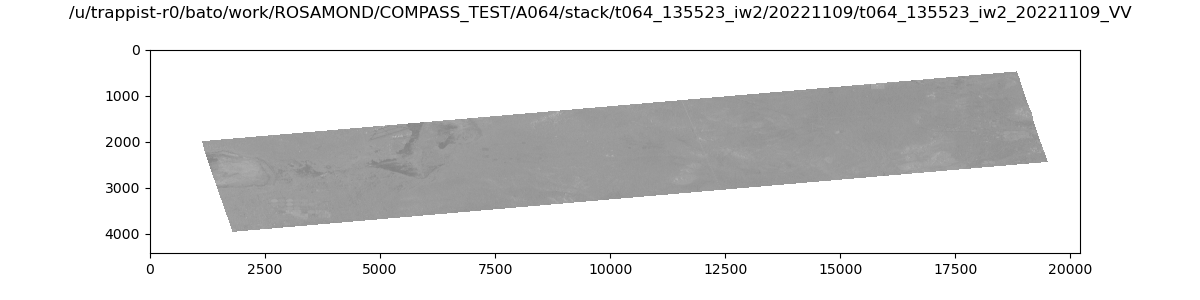

In [4]:
# Visualize CSLC
%matplotlib widget

fig, ax = plt.subplots(figsize=(12, 3))
ax.imshow(20*np.log10(np.abs(cslc)), cmap='gray',interpolation=None, origin='upper')
fig.suptitle(f'{fn.split(".")[0]}')
ax.set_aspect(1)

In [5]:
# Read metadata from the jsonfile
jsonfile = fn.split(".")[0]+'.json'
with open(jsonfile) as fid:
    json_query = json.load(fid)

start_x = json_query['geogrid']['start_x']
start_y = json_query['geogrid']['start_y']
spacing_x = json_query['geogrid']['spacing_x']
spacing_y = json_query['geogrid']['spacing_y']
width = json_query['geogrid']['width']
length = json_query['geogrid']['length']
epsg_no = json_query['geogrid']['epsg']

last_x = start_x + (width-1)*spacing_x
last_y = start_y + (length-1)*spacing_y

# 1. Get corner reflectors data

In [6]:
# Get the cslc date
date_ = dt.datetime.strptime(json_query['sensing_start'],'%Y-%m-%d %H:%M:%S.%f').strftime('%Y-%m-%d+%H\u0021%M')

# Download corner reflector data from NISAR
res = requests.get(f'https://uavsar.jpl.nasa.gov/cgi-bin/corner-reflectors.pl?date={str(date_)}&project=uavsar')
open('crdata.csv', 'wb').write(res.content)

# Read to pandas dataframe and rename columns
df = pd.read_csv('crdata.csv')
df.rename(columns={'Corner reflector ID':'ID'}, inplace=True)
df.rename(columns={'Latitude (deg)':'lat'}, inplace=True) 
df.rename(columns={'Longitude (deg)':'lon'}, inplace=True) 
df.rename(columns={'Azimuth (deg)':'azm'}, inplace=True)
df.rename(columns={'Height above ellipsoid (m)':'hgt'}, inplace=True) 
df.rename(columns={'Side length (m)':'slen'}, inplace=True)

df.head()

,ID,lat,lon,hgt,azm,Tilt / Elevation angle (deg),slen
0,0,34.796969,-118.096530,660.7996,170.5,12.10,2.4384
1,1,34.799849,-118.086988,661.0341,170.5,8.72,2.4384
2,2,34.805238,-118.087389,660.8098,168.5,8.70,2.4384
3,3,34.805338,-118.081944,661.0058,170.0,8.63,2.4384
4,4,34.805415,-118.076378,661.1686,176.0,11.93,2.4384


In [15]:
json_query['border']

'POLYGON ((393390 3837160, 393290 3837240, 393290 3841340, 398810 3861570, 398855 3861590, 399350 3861680, 401905 3862120, 402955 3862300, 423525 3865810, 487230 3876680, 487465 3876720, 487500 3876660, 494290 3841340, 494290 3837240, 493890 3837160, 393390 3837160))'

In [7]:
#calculating the locations of CRs in SAR image
import shapely.wkt
from shapely import geometry

poly = shapely.wkt.loads(json_query['border'])

UTMx = []
UTMy = []
xloc = []
yloc = []
xloc_float = []
yloc_float = []
_in = []

for idx, row in df.iterrows():
    
    _Proj = Proj(CRS.from_epsg(epsg_no))
    _x, _y = _Proj(row['lon'], row['lat'],inverse=False)     #conversion of lat/lon of CRs to UTM coordinates
    
    #location of CRs in SLC image
    _xloc = int((_x-start_x)/spacing_x)    
    _yloc = int((_y-start_y)/spacing_y)
    
    UTMx.append(_x) 
    UTMy.append(_y)
    xloc.append(_xloc)
    yloc.append(_yloc)
    xloc_float.append((_x-start_x)/spacing_x)
    yloc_float.append((_y-start_y)/spacing_y)
    _in.append(poly.contains(geometry.Point(_x, _y)))
    
df['UTMx'] = UTMx
df['UTMy'] = UTMy
df['xloc'] = xloc
df['yloc'] = yloc
df['xloc_float'] = xloc_float
df['yloc_float'] = yloc_float
df['inPoly'] = _in

#checking whether CRs are in SLC coverage. Including only CRs within SLC image
df = df[df['inPoly']==True]
df.drop('inPoly', axis=1, inplace=True)
df = df.reset_index(drop=True)

#### Solid Earth Tide correction
The tidal deformation of the Earth's crust by Sun and Moon is computed by the conventional geodynamic model associated with geodetic reference frames. <br>
<b><I>Note:</I></b> <I>This step requires PySolid for calculating tidal deformation at corner reflectors.</I> 

In [8]:
dateformat = '%Y-%m-%d %H:%M:%S.%f'  #date format of input azimuth time
dt0 = dt.datetime.strptime(json_query['sensing_start'],dateformat)
dt1 = dt.datetime.strptime(json_query['sensing_stop'],dateformat)
step_sec = 5                        # sample spacing in time domain in seconds

for idx, row in df.iterrows():
    
    llh = [np.deg2rad(row['lon']), np.deg2rad(row['lat']), row['hgt']]  #lon/lat/hgt
    
    _elp = ellips()
    xyz = _elp.lon_lat_to_xyz(llh) #xyz coordinate of CR
    
    # compute SET via pysolid
    (dt_out,
     tide_e,
     tide_n,
     tide_u) = pysolid.calc_solid_earth_tides_point(np.rad2deg(llh[1]), np.rad2deg(llh[0]), dt0, dt1,
                                                step_sec=step_sec,
                                                display=False,
                                                verbose=False)
    
    tide_e = np.mean(tide_e[0:2])
    tide_n = np.mean(tide_n[0:2])
    tide_u = np.mean(tide_u[0:2])
    
    #updating lat,lon,hgt after SET correction
    xyz = [xyz[0]+tide_e, xyz[1]+tide_n, xyz[2]+tide_u]
    llh = _elp.xyz_to_lon_lat(xyz)  
    
    df.loc[idx,'lat'] = np.rad2deg(llh[1])
    df.loc[idx,'lon'] = np.rad2deg(llh[0])
    df.loc[idx,'hgt'] = llh[2]   

PYSOLID: calculate solid Earth tides in east/north/up direction
PYSOLID: lot/lon: 34.79696926/-118.09653047 degree
PYSOLID: start UTC: 2022-11-09T01:50:57.827467
PYSOLID: end   UTC: 2022-11-09T01:51:00.925190
PYSOLID: time step: 5 seconds
PYSOLID: calculate solid Earth tides in east/north/up direction
PYSOLID: lot/lon: 34.79984854/-118.08698841999998 degree
PYSOLID: start UTC: 2022-11-09T01:50:57.827467
PYSOLID: end   UTC: 2022-11-09T01:51:00.925190
PYSOLID: time step: 5 seconds
PYSOLID: calculate solid Earth tides in east/north/up direction
PYSOLID: lot/lon: 34.80523753/-118.08738887000001 degree
PYSOLID: start UTC: 2022-11-09T01:50:57.827467
PYSOLID: end   UTC: 2022-11-09T01:51:00.925190
PYSOLID: time step: 5 seconds
PYSOLID: calculate solid Earth tides in east/north/up direction
PYSOLID: lot/lon: 34.80533832/-118.08194447 degree
PYSOLID: start UTC: 2022-11-09T01:50:57.827467
PYSOLID: end   UTC: 2022-11-09T01:51:00.925190
PYSOLID: time step: 5 seconds
PYSOLID: calculate solid Earth t

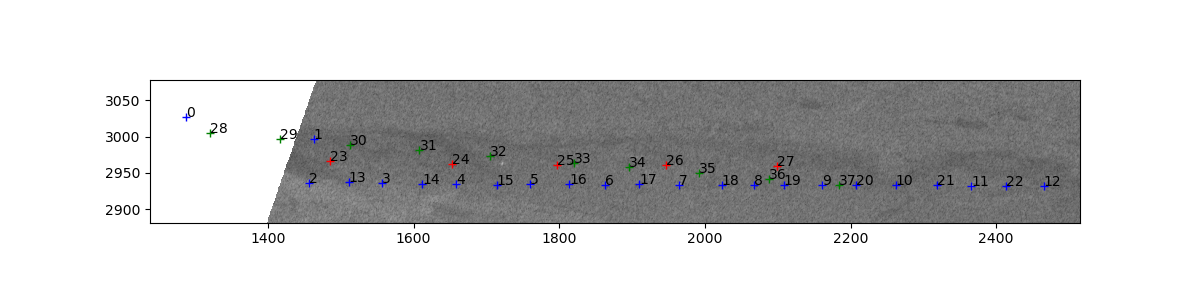

In [9]:
#Displaying SLC image
buffer = 50
minX = df['xloc'].min() - buffer
maxX = df['xloc'].max() + buffer
minY = df['yloc'].min() - buffer
maxY = df['yloc'].max() + buffer

scale_ = 1.0
exp_ = 0.15

fig, ax = plt.subplots(figsize=(12, 3))
cax=ax.imshow(scale_*(np.abs(cslc))**exp_, cmap='gray',interpolation=None, origin='upper')
ax.set_xlim(minX,maxX)
ax.set_ylim(minY,maxY)
#ax.axis('off')

for sl in pd.unique(df.slen):
    xx = df.loc[df['slen']==sl]['xloc']
    yy = df.loc[df['slen']==sl]['yloc']
    ID = df.loc[df['slen']==sl]['ID']
    
    if sl == 2.4384:
        color='blue'
    elif sl == 4.8:
        color='red'
    elif sl == 2.8:
        color='yellow'
    else:
        color='green'
    
    ax.scatter(xx,yy,color=color,marker="+",lw=1)
    for _ID,_xx,_yy in zip(ID,xx,yy):
        ax.annotate(_ID, (_xx, _yy), fontsize=10)

ax.set_aspect(1)
fig.savefig('S1_geoSLC_CRs.png',dpi=300,bbox_inches='tight')

In [10]:
# selecting CRs according to orbit direction
if json_query['orbit_direction'] == 'Descending':
    df_filter = df[df['azm']>340].reset_index(drop=True)
    #only east-looking CRs (for right-looking descending)
else:  #ASCENDING
    df_filter = df[df['azm']<200].reset_index(drop=True)    
    #only west-looking CRs (for right-looking ascending)

df_filter = df_filter.loc[df_filter['slen']>0.8].reset_index(drop=True)   #excluding SWOT CRs (0.7 m as a side length)
df = None

In [11]:
from src.ALE_utils import oversample_slc, findCR

xpeak = []
ypeak = []

for ID, xoff, yoff in zip(df_filter['ID'],df_filter['xloc'],df_filter['yloc']):
    # crop a patch of 10*10 with center at the calculated CR position
    pxbuff = 5
    pybuff = 5
    cropcslc = cslc[(yoff-pybuff):(yoff+pybuff+1),(xoff-pxbuff):(xoff+pxbuff+1)]
    
    # find the peak amplitude in the 10*10 patch
    yind,xind = np.unravel_index(np.argmax(np.abs(cropcslc), axis=None), cropcslc.shape)
    
    # give a warning if the peak and the calculated postion are too far
    dyind = yind-pybuff; dxind = xind-pxbuff
    dist = math.sqrt(dyind**2+dxind**2)
    if dist > 5.0:
        warnings.warn(f'the most bright pixel and the xloc is too far for CR {ID}')
    
    # crop a patch of 32*32 but with its center at the peak
    xbuff = 16
    ybuff = 16
    ycrop = np.arange(yoff+dyind-ybuff,yoff+dyind+ybuff+1)
    xcrop = np.arange(xoff+dxind-xbuff,xoff+dxind+xbuff+1)
    cropcslc = cslc[ycrop,:][:,xcrop]

    # oversample this 32*32 patch by 32
    ovsFactor = 32
    cropcslc_ovs,ycrop_ovs,xcrop_ovs = oversample_slc(cropcslc,sampling=ovsFactor,y=ycrop,x=xcrop)

    # find the peak amplitude again in a 2 x 2 patch, it correspond to 
    # (2*ovsFactor) x (2*ovsFactor) in oversampled slc
    yoff2 = int(cropcslc_ovs.shape[0]/2)
    xoff2 = int(cropcslc_ovs.shape[1]/2)
    cropcslc2 = cropcslc_ovs[yoff2-ovsFactor:yoff2+ovsFactor+1,
                           xoff2-ovsFactor:xoff2+ovsFactor+1]
    yind2,xind2 = np.unravel_index(np.argmax(abs(cropcslc2), axis=None), cropcslc2.shape)
    dyind2 = yind2-ovsFactor; dxind2 = xind2-ovsFactor

    # crop a patch of 3x3 oversampled patch with center at the peak
    cropcslc2 = cropcslc_ovs[yoff2+dyind2-1:yoff2+dyind2+2,xoff2+dxind2-1:xoff2+dxind2+2]
    ycrop2 = ycrop_ovs[yoff2+dyind2-1:yoff2+dyind2+2]
    xcrop2 = xcrop_ovs[xoff2+dxind2-1:xoff2+dxind2+2]
    xxcrop2,yycrop2 = np.meshgrid(xcrop2,ycrop2)
    xxcrop2_f = xxcrop2.flatten()
    yycrop2_f = yycrop2.flatten()
    cropcslc2_f = cropcslc2.flatten()

    # Check if pixel values in a patch are non-NaN
    valid = ~(np.isnan(cropcslc2_f))
    count_valid = np.count_nonzero(valid)

    if count_valid == 0:
        _ypeak, _xpeak = [np.nan, np.nan]

    else:
        _ypeak,_xpeak = findCR(np.abs(cropcslc2_f[valid]),yycrop2_f[valid],xxcrop2_f[valid],
                            x_bound=[xcrop2[0],xcrop2[-1]],y_bound=[ycrop2[0],ycrop2[-1]],method="para")

    xpeak.append(_xpeak)
    ypeak.append(_ypeak)

df_filter['xloc_CR'] = xpeak
df_filter['yloc_CR'] = ypeak

In [12]:
df_filter = df_filter.dropna()
df_filter

,ID,lat,lon,hgt,azm,Tilt / Elevation angle (deg),slen,UTMx,UTMy,xloc,yloc,xloc_float,yloc_float,xloc_CR,yloc_CR
1,1,34.799848,-118.086988,660.945776,170.5,8.72,2.4384,400567.489305,3.851386e+06,1463,2996,1463.497861,2996.427573,1464.185265,2996.049221
2,2,34.805237,-118.087389,660.721467,168.5,8.70,2.4384,400537.330885,3.851984e+06,1457,2936,1457.466177,2936.624209,1457.955569,2936.294619
3,3,34.805337,-118.081944,660.917469,170.0,8.63,2.4384,401035.467538,3.851990e+06,1557,2936,1557.093508,2936.044654,1557.997064,2935.974736
4,4,34.805415,-118.076378,661.080271,176.0,11.93,2.4384,401544.748853,3.851993e+06,1658,2935,1658.949771,2935.736659,1659.988221,2936.049643
5,5,34.805493,-118.070803,661.149974,171.0,11.07,2.4384,402054.791223,3.851996e+06,1760,2935,1760.958245,2935.414675,1762.036629,2934.655128
6,6,34.805584,-118.065225,661.177077,170.0,10.53,2.4384,402565.089818,3.852001e+06,1863,2934,1863.017964,2934.947721,1863.922796,2935.288230
7,7,34.805669,-118.059666,661.240179,172.0,13.40,2.4384,403073.687703,3.852005e+06,1964,2934,1964.737541,2934.542685,1965.204303,2933.716992
8,8,34.805751,-118.054073,661.353981,172.0,10.10,2.4384,403585.384089,3.852008e+06,2067,2934,2067.076818,2934.174135,2067.651441,2934.110085
9,9,34.805813,-118.048915,661.370584,175.0,10.63,2.4384,404057.300255,3.852010e+06,2161,2933,2161.460051,2933.975340,2161.989868,2933.459387
10,10,34.805925,-118.043367,661.439386,177.0,9.80,2.4384,404564.935724,3.852017e+06,2262,2933,2262.987145,2933.269792,2263.862656,2933.400376


In [13]:
#absloute geolocation error in range and azimuth after corrections
ALE_Rg = (df_filter['xloc_CR'] -  df_filter['xloc_float'])
ALE_Az = (df_filter['yloc_CR'] - df_filter['yloc_float'])

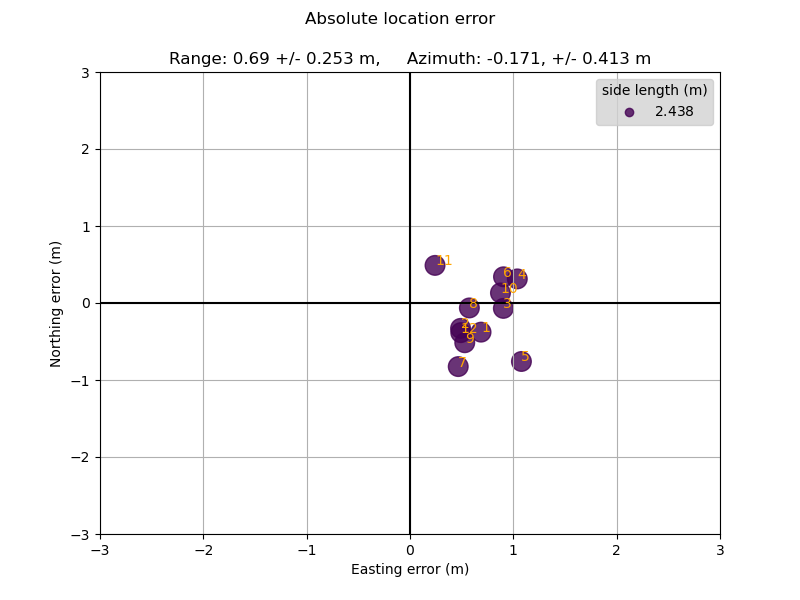

In [14]:
#plotting ALE
fig, ax = plt.subplots(figsize=(8,6))
sc = ax.scatter(ALE_Rg, ALE_Az, s=200, c=df_filter['slen'], alpha=0.8, marker='o')
ax.legend(*sc.legend_elements(),facecolor='lightgray')
ax.get_legend().set_title('side length (m)')
for ii, txt in enumerate(df_filter.iloc[:,0]):
    ax.annotate(txt, (ALE_Rg[txt],ALE_Az[txt]), color='orange')   #putting IDs in each CR
ax.grid(True)
ax.set_xlim(-3,3)
ax.set_ylim(-3,3)
ax.axhline(0, color='black')
ax.axvline(0, color='black')
ax.set_title(f'Range: {np.round(np.nanmean(ALE_Rg), 3)} +/- {np.round(np.nanstd(ALE_Rg),3)} m, \
    Azimuth: {np.round(np.nanmean(ALE_Az),3)}, +/- {np.round(np.nanstd(ALE_Az),3)} m')
ax.set_xlabel('Easting error (m)')
ax.set_ylabel('Northing error (m)')
fig.suptitle('Absolute location error')
fig.savefig('ALE_geoSLC.png',dpi=300,bbox_inches='tight')